In [ ]:
# Install correct PyTorch + CUDA version for Colab
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric packages that match this CUDA version
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install torch-geometric itself
!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cu118 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.1.0+cu118
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

print(data)
print("Classes:", dataset.num_classes)
print("Features per node:", dataset.num_node_features)


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Classes: 7
Features per node: 1433


Done!


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
val_accs = []

best_val_acc = 0
patience = 20
counter = 0
best_model_state = None

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum() / data.val_mask.sum()
        val_accs.append(val_acc.item())

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Use the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Early stopping at epoch 46


In [ ]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
print("Test Accuracy:", float(test_acc))

Test Accuracy: 0.8100000023841858


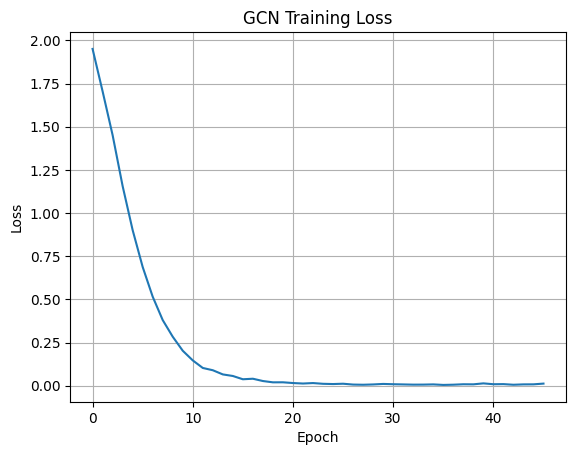

In [ ]:
plt.plot(train_losses)
plt.title("GCN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


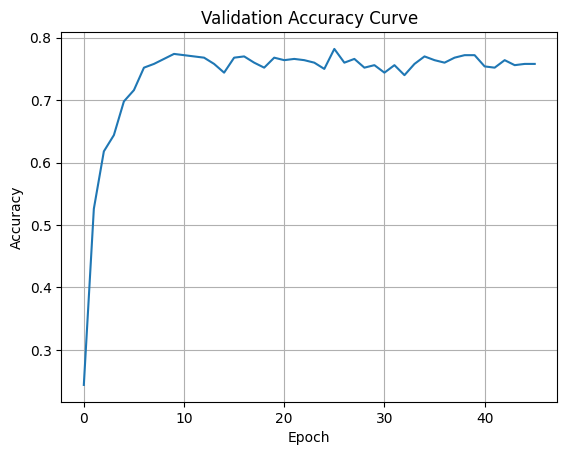

In [ ]:
plt.plot(val_accs)
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


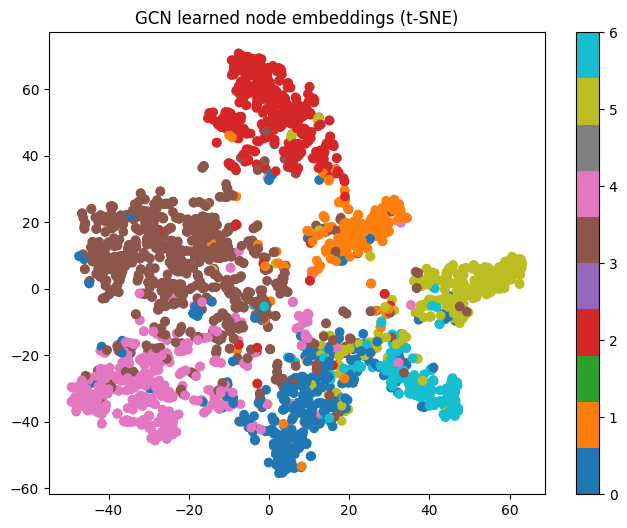

In [ ]:
from sklearn.manifold import TSNE

model.eval()
emb = model(data.x, data.edge_index).detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate='auto')
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=data.y.cpu(), cmap="tab10")
plt.title("GCN learned node embeddings (t-SNE)")
plt.colorbar()
plt.show()


I experimented with several GCN architectures to perform node classification on the Cora dataset. My experiments included models with multiple GCN layers, residual connections, batch normalization, and dropout to improve learning and prevent overfitting.

 Despite increasing the complexity of the models, the highest accuracy was still achieved by a simpler two-layer GCN. This is because the Cora dataset is relatively simple: although each node has 1433 features, the graph itself is small (2708 nodes) and well-structured, with clear separations between classes. In such cases, deeper and more complex models tend to overfit or suffer from over-smoothing, where node representations become too similar across the graph.
